In [1]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, ZeroPadding2D, \
    Dropout, Conv2DTranspose, Cropping2D, Add, UpSampling2D, BatchNormalization
from keras.layers.merge import concatenate
from image_segmentation_keras.keras_segmentation.models.model_utils import get_segmentation_model
from glob import glob

import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

i=0
# Open a strategy scope.
if i==0:
    input_height = 512
    input_width = 512
    n_classes = 2
    channels = 3

    img_input = Input(shape=(input_height,input_width, channels))

    conv0 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
#     conv0 = Dropout(0.2)(conv0)
    conv0 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv0)
    bn0 = BatchNormalization()(conv0)
    pool0 = MaxPooling2D((2, 2))(bn0)
    
    conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool0)
#     conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv3)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(bn3)
    
    conv4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv4)
    print("conv4",conv4.shape)
    print('conv3',conv3.shape)

    up_= Conv2DTranspose(512,(2,2),strides=2,padding='same')(conv4)
    print('up_',up_.shape)
    up0 = concatenate([up_, conv3], axis=3)
    print(up0.shape)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up0)
#     conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    bn4 = BatchNormalization()(conv5)
    
    up_2= Conv2DTranspose(256,(2,2),strides=2,padding='same')(bn4)
    up1 = concatenate([up_2, conv2], axis=-1)
    print(up1.shape)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
#     conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    bn5 = BatchNormalization()(conv6)
    
    up_3= Conv2DTranspose(128,(2,2),strides=2,padding='same')(bn5)
    up2 = concatenate([up_3, conv1], axis=3)
    print(up2.shape)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
#     conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    bn6 = BatchNormalization()(conv7)
    
    up_4= Conv2DTranspose(64,(2,2),strides=2,padding='same')(bn6)
    up3 = concatenate([up_4, conv0], axis=3)
    print(up3.shape)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
#     conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    bn7 = BatchNormalization()(conv8)
    print(conv8.shape)
    out = Conv2D( n_classes, (1, 1) , padding='same')(bn7)
    print('out',out.shape)
    model = get_segmentation_model(img_input ,  out ) # this would build the segmentation model

Using TensorFlow backend.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
conv4 (None, 32, 32, 1024)
conv3 (None, 64, 64, 512)
up_ (None, None, None, 512)
(None, 64, 64, 1024)
(None, 128, 128, 512)
(None, 256, 256, 256)
(None, 512, 512, 128)
(None, 512, 512, 64)
out (None, 512, 512, 2)


In [2]:
model.train(
    train_images = "/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_train_renamed/imgs/",
    train_annotations = "/Users/mavaylon/Research/Davis/Original_Davis/DB_ann/",
    epochs=20,
    steps_per_epoch=len(glob("/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_train_renamed/imgs/*")),
    batch_size=1,
    validate=True,
    val_images="/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_val_renamed/img/",
    val_annotations="/Users/mavaylon/Research/Davis/Original_Davis/DB_ann_val/",
    val_batch_size=1,
    val_steps_per_epoch=len(glob("/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_val_renamed/img/*"))
)


Verifying training dataset


 14%|█▎        | 29/214 [00:00<00:00, 285.37it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 214/214 [00:00<00:00, 320.19it/s]


Dataset verified! 
correct
Epoch 1/20


KeyboardInterrupt: 

In [2]:
model.load_weights('/Users/mavaylon/Research/davis_weights/unet_vanilla_davis.h5')

In [23]:
import glob

img_names = glob.glob('/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/img/*')

for name in img_names:
    out_name = "/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/" + name.split('/')[-1]
    print(out_name)
    out = model.predict_segmentation(inp=name, out_fname=out_name)

/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_6.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_26.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucsf_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_6.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_29.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt053_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_15.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt053_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_29.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it30

/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucsf_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_2.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_22.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_2.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Pt026_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_4.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_5.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_4.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Pt026_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_5.png
/Us

/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt074_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_3.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Pt008_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_6.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_12.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucsf_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_15.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_10.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt074_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_1.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Pt008_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_4.png
/

/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_18.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt053_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_30.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt074_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_15.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt044_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_24.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt053_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_18.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt074_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_6.png
/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Pt008_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
test=cv2.imread('/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Ucirvine_Pt022_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_6.png')

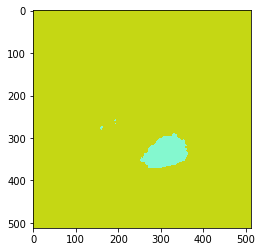

In [6]:
plt.imshow(test)

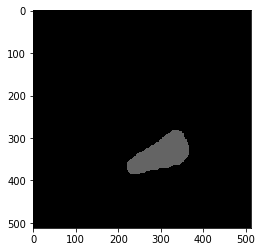

In [14]:
test_gt=cv2.imread('/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/ann/Lipomaalt_Ucirvine_Pt022_mrmask_mrmask_i512_n4corr_l4_it300_slice_6.png')
plt.imshow(test_gt*100)


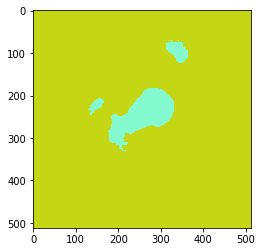

In [19]:
test2=cv2.imread('/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/Lipomaalt_Mcgill_Pt074_mrimg_n4corr_l4_it300_mrimg_i512_n4corr_l4_it300_slice_18.png')
plt.imshow(test2)

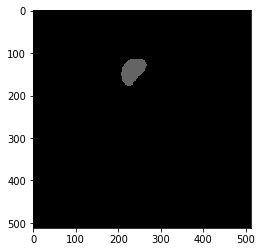

In [20]:
test2gt=cv2.imread('/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/ann/Lipomaalt_Mcgill_Pt074_mrmask_mrmask_i512_n4corr_l4_it300_slice_18.png')
plt.imshow(test2gt*100)

In [27]:
# import glob

# img_names = glob.glob('/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/img/*')

# for name in img_names:
#     out_name = "/Users/mavaylon/Research/Results/Davis_Results/UNET/Vanilla/" + name.split('/')[-1]
#     print(out_name)
model.evaluate_segmentation(inp_images_dir='/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/img', annotations_dir='/Users/mavaylon/Research/Davis/Original_Davis/proximal_lower_contrast_test/ann')



0it [00:00, ?it/s]

1it [00:01,  1.50s/it]

2it [00:02,  1.49s/it]

3it [00:04,  1.48s/it]

4it [00:05,  1.47s/it]

5it [00:07,  1.47s/it]

6it [00:08,  1.50s/it]

KeyboardInterrupt: 